<a href="https://colab.research.google.com/github/shobhittya/MiniNet/blob/main/RealNet_First.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Mar 24 04:02:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
import tensorflow_addons as tfa

In [4]:
import os
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
#import necessary libraries

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt2
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [6]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url = "https://www.kaggle.com/xhlulu/140k-real-and-fake-faces"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


100%|██████████| 3.75G/3.75G [01:35<00:00, 42.1MB/s]


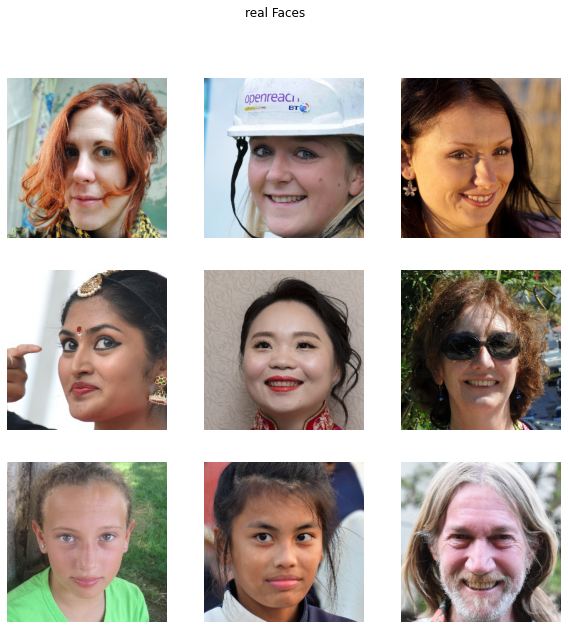

In [7]:
# path = '/content/gdrive/MyDrive/dataset'

path = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

plot_img(path, 'real').show()

In [8]:
bs = 64
row, col = 224, 224
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True
                                  )
training_set = train_datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_set = val_test_datagen.flow_from_directory(path + '/valid',
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
test_set = val_test_datagen.flow_from_directory(path + '/test',
                                                class_mode='binary',
                                                shuffle=True,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
training_set.class_indices

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

**RealNet**

In [9]:
def real_block(input, dim, drop_path=0.0):
  """
  ConvNeXt Block

  Input Parameters:

  input: input tensor
  dim: Number of filters/channels
  drop_path: Set to 0 by default
  ----------------------

  About the block:
    - 7x7 depthwise conv(can be implemented from Conv2D, no of groups = no of filters)
    - 2 1x1 convs or pointwise layers are equivalent to dense layers(or fully connected layer) operating independently on each channel
    - The number of channels in the first 1x1 conv is 4 times the input dimension.
    - The channels for the last 1x1 conv are similar to input channels. See the block.
    - Layer normalization layer comes before the first 1x1 conv
    - GELU layer is inserted between two 1x1 convs
    - There is a direct shortcut from the input of the block to the output
  """
  shortcurt = input #shortcut connection
  x = layers.Conv2D(filters=dim, kernel_size=7, padding='same', groups=dim)(input)
  x = layers.LayerNormalization(epsilon=1e-6)(x)
  x = layers.Dense(4 * dim)(x)
  x = layers.Activation('gelu')(x)
  x = layers.Dense(dim)(x)
  
  #Stochastic depth
  drop_depth = tfa.layers.StochasticDepth(drop_path) if drop_path > 0.0 else layers.Activation("linear")

  output = layers.Add()([shortcurt, drop_depth(x)])

  return output

In [10]:
def stem(input, dim):

  x = layers.Conv2D(filters=dim, kernel_size=4, strides=4)(input)
  x = layers.LayerNormalization(epsilon=1e-6)(x)

  return x

In [11]:
def downsampling_layers(input, dim):

  x = layers.LayerNormalization(epsilon=1e-6)(input)
  x = layers.Conv2D(filters=dim, kernel_size=2, strides=2)(x)

  return x

**Building RealNet Network**

In [35]:
def real_model(input_shape=(224, 224, 3), dims=[96, 192, 384, 768], num_classes=2):

  input = layers.Input(input_shape)

  # stem
  x = stem(input, dims[0])

  # Convnext stage 1 x3, dim[0] = 64
  for _ in range(1):
    x = real_block(x, dims[0])

  # Downsampling layers + stage 2 x3, dim[1] = 128
  x = downsampling_layers(x, dims[1])
  for _ in range(3):
    x = real_block(x, dims[1])

  # Downsampling layers + stage 3 x7, dim[2] = 256
  x = downsampling_layers(x, dims[2])
  for _ in range(6):
    x = real_block(x, dims[2])

  # Downsampling layers + stage 4 x3, dim[3] = 512
  x = downsampling_layers(x, dims[3])
  for _ in range(1):
    x = real_block(x, dims[3])
    
  # Classification head: Global average pool + layer norm + fully connected layer
  x = layers.GlobalAvgPool2D()(x)
  
#   x = layers.LayerNormalization(epsilon=1e-6)(x)
  x = layers.BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None) (x)
  x = layers.Dense(units=dims[3], activation='softmax')(x)
  x = layers.Dropout(0.2)(x)
  output = layers.Dense(units=num_classes, activation='softmax')(x)

  model = keras.Model(input, output, name='ConvNeXt')

  return model

In [ ]:
real_net = real_model()
real_net.summary()

In [37]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [38]:
EPOCHS = 200
WARMUP_STEPS = 20
INIT_LR = 0.04
WAMRUP_LR = 0.006
BATCH_SIZE = 64


TOTAL_STEPS = int((2000 / BATCH_SIZE) * EPOCHS)
# TOTAL_STEPS = 100

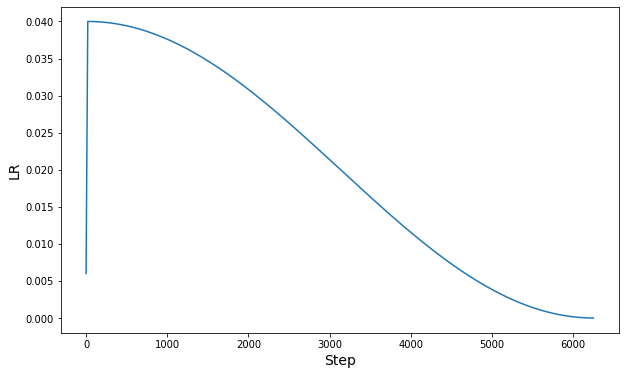

In [39]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [40]:
optimizer = tf.keras.optimizers.SGD(scheduled_lrs)
loss = keras.losses.SparseCategoricalCrossentropy()


In [41]:
model = real_model()
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

In [42]:
history = model.fit(training_set, validation_data=validation_set, epochs=30)

Epoch 1/30
1563/1563 [==============================] - 931s 592ms/step - loss: 0.6340 - accuracy: 0.6244 - val_loss: 0.6609 - val_accuracy: 0.6511
Epoch 2/30
1563/1563 [==============================] - 924s 591ms/step - loss: 0.5035 - accuracy: 0.7436 - val_loss: 0.4278 - val_accuracy: 0.8256
Epoch 3/30
1563/1563 [==============================] - 924s 591ms/step - loss: 0.3994 - accuracy: 0.8221 - val_loss: 0.3001 - val_accuracy: 0.8962
Epoch 4/30
1563/1563 [==============================] - 924s 591ms/step - loss: 0.3244 - accuracy: 0.8935 - val_loss: 0.2629 - val_accuracy: 0.9118
Epoch 5/30
1563/1563 [==============================] - 925s 591ms/step - loss: 0.3106 - accuracy: 0.9043 - val_loss: 0.2626 - val_accuracy: 0.9109
Epoch 6/30
1563/1563 [==============================] - 925s 592ms/step - loss: 0.3090 - accuracy: 0.9037 - val_loss: 0.2629 - val_accuracy: 0.9108
Epoch 7/30
  38/1563 [..............................] - ETA: 14:09 - loss: 0.3106 - accuracy: 0.9058

KeyboardInterrupt: ignored

**Predictions**

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_set)

 95/313 [========>.....................] - ETA: 39s - loss: 0.2687 - accuracy: 0.9048